In [1]:
%cd ..
%cd ..

c:\Users\jonat\Desktop\MSAS\WetLabColorMatchingAI\color_matching
c:\Users\jonat\Desktop\MSAS\WetLabColorMatchingAI


In [2]:
from pathlib import Path
#import sys 
#sys.path.insert(0, str(Path().resolve().parent.parent))

from color_matching.robot.ot2_utils import OT2Manager
import numpy as np
import random
import pandas as pd
from camera.camera_w_calibration import PlateProcessor
import json
import time

FORCE_REMOTE = True
VIRTUAL_MODE = False 
OT_NUMBER = 4

COLORS = ["red", "yellow", "blue"]

# ——— info.json ———
# Print the current directory
print("Current directory:", Path().resolve())
# Change the directory to two directories up

with open(f"secret/OT_{OT_NUMBER}/info.json", "r") as f:
    info = {}
    info.update(json.load(f))
    local_ip = info.get("local_ip", "169.254.122.0")
    local_password = info.get("local_password", "lemos")
    local_password = None if local_password == "None" else local_password

    remote_ip = info.get("remote_ip", "172.26.192.201")
    remote_password = info.get("remote_password", "None")
    remote_password = None if remote_password == "None" else remote_password

    CAM_INDEX = info.get("cam_index", 1)


# Define plate rows and columns
plate_rows_letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
plate_col_letters = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

# Define color slots
color_slots = {COLORS[0]: "7", COLORS[1]: "8", COLORS[2]: "9", "water": "11"}

Current directory: C:\Users\jonat\Desktop\MSAS\WetLabColorMatchingAI


In [3]:
# Instantiate OT2Manager and PlateProcessor
if not FORCE_REMOTE:
    robot = OT2Manager(
        hostname=local_ip,
        username="root",
        key_filename=f"secret/OT_{OT_NUMBER}/ot2_ssh_key",
        password=local_password,
        reduced_tips_info=4,
        bypass_startup_key=True,
        virtual_mode=VIRTUAL_MODE,
    )
else:
    # fallback remote
    robot = OT2Manager(
        hostname=remote_ip,
        username="root",
        key_filename=f"secret/OT_{OT_NUMBER}/ot2_ssh_key_remote",
        password=remote_password,
        reduced_tips_info=4,
        bypass_startup_key=True,
        virtual_mode=VIRTUAL_MODE
    )

robot.add_turn_on_lights_action()
robot.execute_actions_on_remote()

print("Lights turned on.")
time.sleep(2)  # wait for lights to stabilize

Connecting to OT2 robot at 172.26.192.201...
Saved args to robot/args.jsonx
Uploading file using SCP...
Uploaded 'robot/args.jsonx' to /root/ on the OT2 robot.
Uploading file using SCP...
Uploaded 'color_matching/remote/remote_ot2_color_learning_main.py' to /root/ on the OT2 robot.
Waiting for robot to finish... [Attempt #1]Starting remote robot listener via interactive shell...
@@@@@    @@@@@
@@@@          @@@@
@@@      @@      @@@    @@@@@@   @@@@@
@@@      @@@@      @@@   @@@@@@  &@' '@@
@@     @@@@@@@@    &@@     @@         @@
@@    .@@@    @    #@@     @@        @@
@@@    @      @    @@@     @@       @@
@@@    @@..@@    @@@      @@      @@
@@@@          @@@@       @@     @@@@@&
@@@@@@@@@@@@@@         ##    &@@@@@#
(@@@@@@.
export RUNNING_ON_PI=1
cd /root/
STATUS=$(systemctl is-active opentrons-robot-server)
echo Service is: $STATUS
if [ "$STATUS" = "active" ]; then
echo Stopping robot server...
systemctl stop opentrons-robot-server
else
echo Robot server is not running. No need to

In [4]:
processor = PlateProcessor(virtual_mode=VIRTUAL_MODE)

# Generate the Recipes and Save to CSV

In [5]:
# Create a 96 well plate
def create_linspace_recipe(start: int, end: int, num: int, color: str, total_volume: int = 200) -> list[dict[str, int]]:
    """Create a list of linear space recipes for the given start and end concentrations.
    Every recipe will have a total volume of 200uL, supplemented with water."""
    linspace = np.linspace(start, end, num=num)
    recipes = []
    for concentration in linspace:
        recipe = {color: int(concentration), "water": total_volume - int(concentration)}
        recipes.append(recipe)
    return recipes

def create_replicate_linspace_recipe(start: int, end: int, num: int, color: str, total_volume: int = 200, replicates: int = 4) -> list[dict[str, int]]:
    """Create a list of linear space recipe replicates for the given start and end concentrations.
    Every recipe will have a total volume of 200uL, supplemented with water."""
    recipes = []
    for _ in range(replicates):
        recipes.extend(create_linspace_recipe(start, end, num, color, total_volume))
    return recipes

def create_random_recipe(colors: list[str], total_volume: int = 200, min_volume: int = 20) -> dict[str, int]:
    """Create a random recipe for the given colors with a total volume of 200uL.
    Note that while the default minimum volume is "20uL", that's only the minimum _if the color is present_.
    If the color is not present, it will be 0uL.
    """
    recipe = {}
    total_volume_remaining = total_volume
    for idx, color in enumerate(colors):
        if random.random() < 0.5 and total_volume_remaining >= min_volume:
            # Ensure we don't try to assign more than we have left
            max_vol = total_volume_remaining - min_volume * (len(colors) - idx - 1)
            if max_vol < min_volume:
                volume = total_volume_remaining
            else:
                volume = random.randint(min_volume, max_vol)
            recipe[color] = volume
            total_volume_remaining -= volume
        else:
            recipe[color] = 0
    recipe["water"] = total_volume_remaining
    return recipe

# Create recipes:
# Quadruplicate linear space recipes with 4 wells each for each primary color
# With 3 primary colors, this will 4*4*3 = 48 wells
# Then, with the remaining 48 wells, create random recipes 
protocol_recipes = []
for color in COLORS:
    protocol_recipes.extend(create_replicate_linspace_recipe(20, 200, 4, color, total_volume=200, replicates=4))
# Add random recipes for the remaining wells
for _ in range(48):
    protocol_recipes.append(create_random_recipe(COLORS, total_volume=200, min_volume=20))

# Now, randomly shuffle the recipes then add them to the plate
random.shuffle(protocol_recipes)
# Add recipes to the plate as well as a dataframe
# df will include the following columns:
# well, color1_vol, color2_vol, color3_vol, water_vol, measured_red, measured_green, measured_blue
# The measured columns will be filled in later
df = pd.DataFrame(columns=["well", f"{COLORS[0]}_vol", f"{COLORS[1]}_vol", f"{COLORS[2]}_vol", "water_vol", "measured_red", "measured_green", "measured_blue"])

# Collect rows for batch DataFrame creation
df_rows = []
for i, recipe in enumerate(protocol_recipes):
    row = plate_rows_letters[i // 12]
    col = plate_col_letters[i % 12]
    well = f"{row}{col}"
    
    df_rows.append([
        well,
        recipe.get(COLORS[0], 0),
        recipe.get(COLORS[1], 0),
        recipe.get(COLORS[2], 0),
        recipe.get("water", 0),
        None,  # Placeholder for measured red
        None,  # Placeholder for measured green
        None,  # Placeholder for measured blue
    ])
# Create DataFrame in one go
if len(df_rows) > 0:
    df = pd.DataFrame(df_rows, columns=df.columns)

# Immediately save the initial DataFrame to a CSV file
df.to_csv("linspace_data_initial.csv", index=False)

# Load Recipes from CSV and Execute on Robot

In [ ]:
df = pd.read_csv("linspace_data_initial.csv")
# Add the recipes to the plate
# We'll use the 'well' column from the DataFrame directly
for color in COLORS:
    robot.add_get_tip_action(tip_ID=color)
    for i, recipe in df.iterrows():
        well = recipe["well"]
        color_volume = recipe[f"{color}_vol"]
        if color_volume > 0:
            robot.add_add_color_action(
                color_slot=color_slots[color],
                plate_well=well,
                volume=color_volume,
                new_tip=False
            )
    robot.add_return_tip_action(tip_ID=color)
# Add water to the plate
robot.add_get_tip_action(tip_ID="water")
for i, recipe in df.iterrows():
    well = recipe["well"]
    water_volume = recipe["water_vol"]
    if water_volume > 0:
        robot.add_add_color_action(
            color_slot=color_slots["water"],
            plate_well=well,
            volume=water_volume,
            new_tip=False
        )
robot.add_return_tip_action(tip_ID="water")

# Execute actions
robot.execute_actions_on_remote()

Added action: get_tip with value: {'tip_ID': 'red'}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'A2', 'volume': 200, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'A5', 'volume': 35, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'A7', 'volume': 72, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'A8', 'volume': 140, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'A11', 'volume': 200, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'A12', 'volume': 90, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'B1', 'volume': 105, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'B3', 'volume': 140, 'new_tip': False}
Added action: add_color with value: {'color_slot': '7', 'plate_well': 'B4', '

Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)


Remote shell channel closed.Remote shell channel closed.

Waiting for robot to finish... [Attempt #272]

# Mix Manually or Robotically
manual or robotic mixing

# Measurement 1

In [6]:
df = pd.read_csv("linspace_data_initial.csv")
protocol_recipes = df.to_dict(orient="records")
measured_plate = processor.process_image(cam_index=CAM_INDEX, calib=f"secret/OT_{OT_NUMBER}/calibration.json")
for i, recipe in enumerate(protocol_recipes):
    row = plate_rows_letters[i // 12]
    col = plate_col_letters[i % 12]
    row_idx = ord(row) - ord("A")
    col_idx = int(col) - 1
    rgb = measured_plate[row_idx, col_idx]
    # Store the measured RGB values in the dataframe
    df.at[i, "measured_red"] = rgb[0]
    df.at[i, "measured_green"] = rgb[1]
    df.at[i, "measured_blue"] = rgb[2]

Warming up camera...
Capturing burst...
[Saved] Raw matrix to camera/raw_matrix.json
[Saved] Corrected matrix to camera/corrected_matrix.json
[Saved] camera/output_with_centers_corr.jpg


# Turn the Plate 180 Degrees
# Measurement 2 and Save

In [7]:
measured_plate_prime = processor.process_image(cam_index=CAM_INDEX, calib=f"secret/OT_{OT_NUMBER}/calibration.json")
prime_rows = []
for i, recipe in enumerate(reversed(protocol_recipes)):
    # Calculate the well index after rotation
    rotated_index = 95 - i  # 0-based index for 96-well plate
    row = plate_rows_letters[rotated_index // 12]
    col = plate_col_letters[rotated_index % 12]
    well = f"{row}{col}'"  # Mark as prime
    row_idx = ord(row) - ord("A")
    col_idx = int(col) - 1
    rgb = measured_plate_prime[row_idx, col_idx]
    # Collect new row for the rotated measurement
    prime_rows.append([
        well,
        recipe.get(COLORS[0], 0),
        recipe.get(COLORS[1], 0),
        recipe.get(COLORS[2], 0),
        recipe.get("water", 0),
        rgb[0],
        rgb[1],
        rgb[2],
    ])
if len(prime_rows) > 0:
    df_prime = pd.DataFrame(prime_rows, columns=df.columns)
    df = pd.concat([df, df_prime], ignore_index=True)

# Save the dataframe to a CSV file
df.to_csv("linspace_data.csv", index=False)

Warming up camera...
Capturing burst...
[Saved] Raw matrix to camera/raw_matrix.json
[Saved] Corrected matrix to camera/corrected_matrix.json
[Saved] camera/output_with_centers_corr.jpg


# Robot Shutdown

In [8]:
# Turn off lights and close connection
robot.add_turn_off_lights_action()
robot.add_close_action()
robot.execute_actions_on_remote()

Added action: turn_off_lights with value: {}
Added action: close with value: {}
Saved args to robot/args.jsonx
Uploading file using SCP...
Uploaded 'robot/args.jsonx' to /root/ on the OT2 robot.
Waiting for robot to finish... [Attempt #1]args.jsonx is updated. Running commands...
Running turn_off_lights with args: {}
Turning off lights.
Running close with args: {}
Protocol closed.
Moving pipette to trash.
Moving to Trash Bin on slot 12
args.jsonx updated. Waiting for next update...
Ready
Finished flag set to True
Robot finished processing. Finished flag reset.
Actions executed on remote. Ready for new instructions.


# Analysis

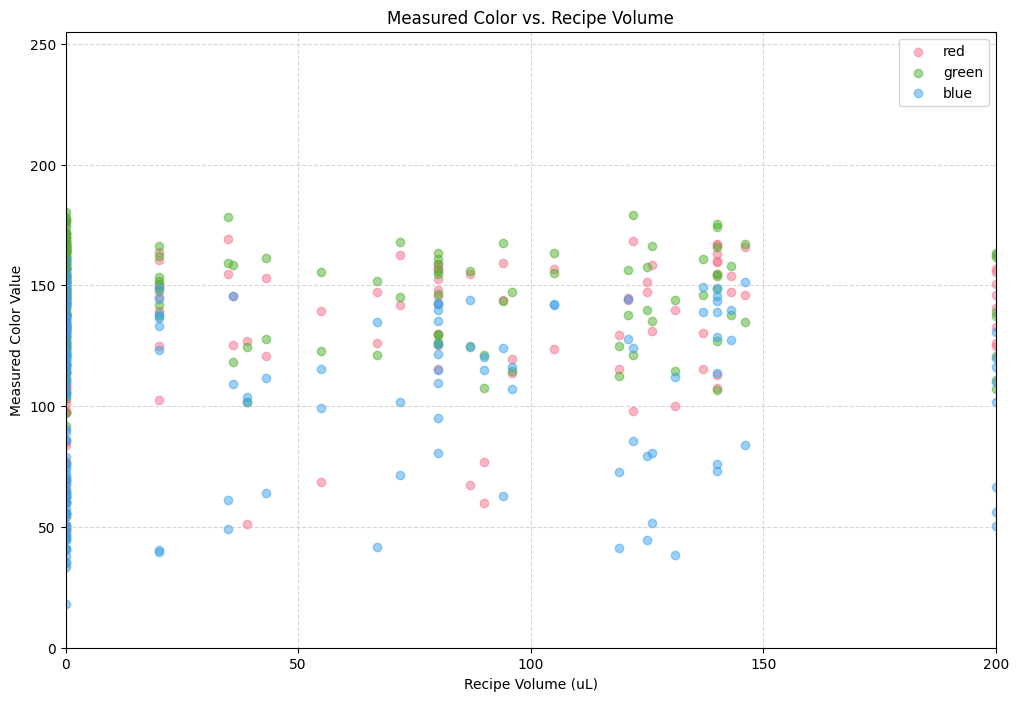

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

df = pd.read_csv("linspace_data.csv")

# Set the color palette
palette = sns.color_palette("husl", 3)
# Create a color map for the colors
cmap = mcolors.ListedColormap(palette)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
# Create a scatter plot for the measured colors
for i, color in enumerate(["red", "green", "blue"]):
    ax.scatter(df[f"red_vol"], df[f"measured_{color}"], color=palette[i], label=color, alpha=0.5)
# Set the axis labels and title
ax.set_xlabel("Recipe Volume (uL)")
ax.set_ylabel("Measured Color Value")
ax.set_title("Measured Color vs. Recipe Volume")
# Set the x and y axis limits
ax.set_xlim(0, 200)
ax.set_ylim(0, 255)
# Set the x and y axis ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
# Add a grid
ax.grid(True, linestyle='--', alpha=0.5)
# Add a legend
ax.legend()
# Show the plot
plt.show()
# Save the plot
plt.savefig("camera/measured_colors.png", dpi=300)